# Emotion Extraction using NLTK, LSTM, and GRU




# Importing the necessary dependencies

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,recall_score,precision_score
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences,to_categorical
from keras.models import Sequential
from keras.layers import Dense,Embedding,SimpleRNN,LSTM,GRU,Bidirectional,Conv1D,MaxPool1D
import warnings
warnings.filterwarnings('ignore')  # To ignore warnings

#Looking at the dataset

In [ ]:
# Importing the train dataset
train_df = pd.read_csv("/content/training.csv")
print("Train data :\n",train_df.head(),"\n")
# Importing the train dataset
test_df = pd.read_csv("/content/test.csv")
print("Test data :\n",test_df.head(),"\n")
# Importing the validation dataset
valid_df = pd.read_csv("/content/validation.csv")
print("Validation data :\n",valid_df.head(),"\n")

Train data :
                                                 text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3 

Test data :
                                                 text  label
0  im feeling rather rotten so im not very ambiti...      0
1          im updating my blog because i feel shitty      0
2  i never make her separate from me because i do...      0
3  i left with my bouquet of red and yellow tulip...      1
4    i was feeling a little vain when i did this one      0 

Validation data :
                                                 text  label
0  im feeling quite sad and sorry for myself but ...      0
1  i feel like i am still looking at a blank canv...      0
2                     i feel like a faithful serva

In [ ]:
print("Train Data shape: ",train_df.shape)
print("Test Data shape: ",test_df.shape)
print("Validation Data shape: ",valid_df.shape)

Train Data shape:  (16000, 2)
Test Data shape:  (2000, 2)
Validation Data shape:  (2000, 2)


In [ ]:
print("Train data info: ",train_df.info())
print("Test data info: ",test_df.info())
print("Validation data info: ",valid_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB
Train data info:  None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
Test data info:  None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
Validation data info:  None


In [ ]:
print(train_df.describe()) # Describeing the numerical data of training dataset

              label
count  16000.000000
mean       1.565937
std        1.501430
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max        5.000000


# Data Analysis

In [ ]:
#Identifying the number of labels present in the label column along with their frequency counts
train_df['label'].value_counts()

label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64

#EDA

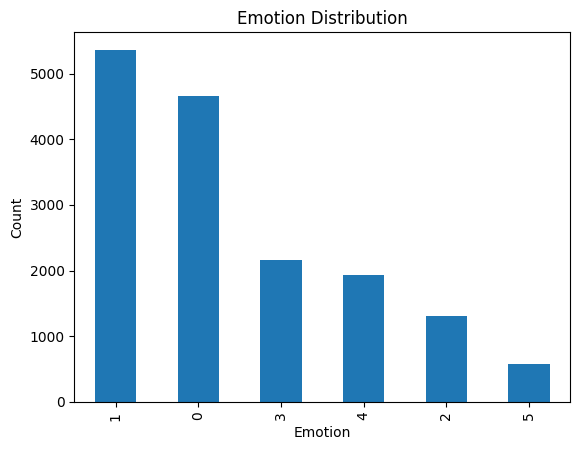

In [ ]:
#Plotting bar plot to illustrate the distribution of labels column across various classes present in it
train_df['label'].value_counts().plot(kind = 'bar')
plt.title("Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

# Data preprocessing

In [ ]:
print("Number of null values present in the training dataset is: ",train_df.isna().sum())
print("Number of duplicate rows present in the training dataset is: ",train_df.duplicated().sum())

Number of null values present in the training dataset is:  text     0
label    0
dtype: int64
Number of duplicate rows present in the training dataset is:  1


In [ ]:
# Dropping the duplicated values
train_df.drop_duplicates(keep = 'first',inplace=True)
print("Number of duplicate rows present in the training dataset is: ",train_df.duplicated().sum())
print("Training dataset shape: ",train_df.shape)

Number of duplicate rows present in the training dataset is:  0
Training dataset shape:  (15999, 2)


## Text Preprocessing

In [ ]:
# Defining punctuation characters
punctuation_chars = string.punctuation

# Regular expression pattern for removing HTML tags from text
html_tag_pattern = re.compile('<.*?>')

# Creating a Tokenizer instance for text processing
tokenizer_instance = Tokenizer()

# Initializing a Porter Stemmer for word stemming
stemmer_instance = PorterStemmer()


# Downloading NLTK stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def preprocess_text(input_text):
    # Convert text to lowercase
    text = input_text.lower()

    # Remove HTML tags from the text
    text = re.sub(html_tag_pattern, '', text)

    # Remove punctuation characters from the text
    text = text.translate(str.maketrans('', '', punctuation_chars))

    # Tokenize the text into words
    tokens = text.split()

    # Initialize a list to store processed tokens
    processed_tokens = []

    # Remove stopwords and apply stemming
    for token in tokens:
        if token not in stopwords.words('english'):
            stemmed_token = stemmer_instance.stem(token)
            processed_tokens.append(stemmed_token)

    # Join processed tokens into a single string
    processed_text = ' '.join(processed_tokens)

    return processed_text


In [ ]:
# Applying text preprocessing function to the 'text' column of the train, valiadtion, and test datasets
processed_train_df = [preprocess_text(text) for text in train_df['text']]
processed_valid_df = [preprocess_text(text) for text in valid_df['text']]
processed_test_df = [preprocess_text(text) for text in test_df['text']]


In [ ]:
# Concatenate all processed text from the training data into a single string
concat_text = ''

for text in processed_train_df:
    concat_text += text

# Fit the tokenizer on the whole concatenated text for word embedding
tokenizer_instance.fit_on_texts([concat_text])

# Print the vocabulary size (number of unique words) in the training data
print("Vocabulary Size:", len(tokenizer_instance.word_index))


Vocabulary Size: 20360


In [ ]:
def x_y_model_data(proc_df,df,tokenizer):
  # Convert each processed text in the test data to numeric sequences
  x_sequences = []

  for processed_text in proc_df:
      # Convert processed text to numeric sequence using tokenizer
      sequence = tokenizer.texts_to_sequences([processed_text])[0]
      x_sequences.append(sequence)

  # Pad each sequence to ensure uniform length
  maxlen = 50  # Maximum sequence length
  x_padseq = pad_sequences(x_sequences, maxlen=maxlen, padding='post')

  # Convert to numpy arrays for model testing
  x_model = np.array(x_padseq)  # Features for testing
  y_model = np.array(df['label'])
  y_model=tf.keras.utils.to_categorical(y_model, num_classes=6)  # Labels for testing
  return x_model,y_model


In [ ]:
x_train_model,y_train_model = x_y_model_data(processed_train_df,train_df,tokenizer_instance)
x_test_model,y_test_model = x_y_model_data(processed_test_df,test_df,tokenizer_instance)
x_validation_model,y_validation_model = x_y_model_data(processed_valid_df,valid_df,tokenizer_instance)

# 4. Model Building and Model Training

In [ ]:
# Defining yperparameter of emebedding
vocabulary_size = len(tokenizer_instance.word_index)
embedding_dim = 50
max_sequence_length = 50
num_classes = 6

In [ ]:
# Define a Bidirectional LSTM model
bi_lstm_model = Sequential()

# Add an Embedding layer
bi_lstm_model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_sequence_length))

# Add a Bidirectional LSTM layer with 100 units
bi_lstm_model.add(Bidirectional(LSTM(units=100)))

# Add a Dense layer with softmax activation for multi-class classification (assuming 6 classes)
bi_lstm_model.add(Dense(units=num_classes, activation='softmax'))

# Compile the model with categorical crossentropy loss, adam optimizer, and accuracy metric
bi_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary to show model architecture
bi_lstm_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            1018000   
                                                                 
 bidirectional (Bidirection  (None, 200)               120800    
 al)                                                             
                                                                 
 dense (Dense)               (None, 6)                 1206      
                                                                 
Total params: 1140006 (4.35 MB)
Trainable params: 1140006 (4.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Bidirectional LSTM model Training
num_epcoh = 5
batch_size = 32

bi_lstm_model_training_history = bi_lstm_model.fit(x = x_train_model, y = y_train_model, validation_data = (x_validation_model,y_validation_model), epochs = num_epcoh, batch_size = batch_size)

Epoch 1/5
500/500 [==============================] - 54s 97ms/step - loss: 1.0857 - accuracy: 0.5958 - val_loss: 0.5249 - val_accuracy: 0.8125
Epoch 2/5
500/500 [==============================] - 47s 94ms/step - loss: 0.2985 - accuracy: 0.8938 - val_loss: 0.3453 - val_accuracy: 0.8720
Epoch 3/5
500/500 [==============================] - 50s 99ms/step - loss: 0.1590 - accuracy: 0.9418 - val_loss: 0.3371 - val_accuracy: 0.8830
Epoch 4/5
500/500 [==============================] - 47s 94ms/step - loss: 0.1044 - accuracy: 0.9616 - val_loss: 0.3539 - val_accuracy: 0.8805
Epoch 5/5
500/500 [==============================] - 47s 93ms/step - loss: 0.0778 - accuracy: 0.9716 - val_loss: 0.3818 - val_accuracy: 0.8875


In [ ]:
# Create a Sequential model for LSTM
custom_lstm_model = Sequential()

# Add an Embedding layer
custom_lstm_model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_sequence_length))

# Add an LSTM layer with 100 units and 'relu' activation function
custom_lstm_model.add(LSTM(units=100, activation='relu'))

# Add a Dense layer with softmax activation for multi-class classification (assuming 6 classes)
custom_lstm_model.add(Dense(units=num_classes, activation='softmax'))

# Compile the model with categorical crossentropy loss, adam optimizer, and accuracy metric
custom_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary to show model architecture
custom_lstm_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 50)            1018000   
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dense_1 (Dense)             (None, 6)                 606       
                                                                 
Total params: 1079006 (4.12 MB)
Trainable params: 1079006 (4.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the LSTM model
epochs_lstm = 5
batch_size_lstm = 32

lstm_model_history = custom_lstm_model.fit(x = x_train_model, y = y_train_model, validation_data = (x_validation_model,y_validation_model), epochs = epochs_lstm, batch_size = batch_size_lstm)

Epoch 1/5
500/500 [==============================] - 33s 62ms/step - loss: 6.1358 - accuracy: 0.3244 - val_loss: 2.4124 - val_accuracy: 0.3520
Epoch 2/5
500/500 [==============================] - 34s 68ms/step - loss: 1.2779 - accuracy: 0.4010 - val_loss: 1.1657 - val_accuracy: 0.5060
Epoch 3/5
500/500 [==============================] - 32s 63ms/step - loss: 0.9786 - accuracy: 0.6317 - val_loss: 0.9974 - val_accuracy: 0.6520
Epoch 4/5
500/500 [==============================] - 31s 63ms/step - loss: 0.7849 - accuracy: 0.7367 - val_loss: 0.9776 - val_accuracy: 0.7135
Epoch 5/5
500/500 [==============================] - 31s 62ms/step - loss: 14.5680 - accuracy: 0.6144 - val_loss: 0.9252 - val_accuracy: 0.6965


In [ ]:
# Define a Stacked LSTM model
stacked_lstm_model = Sequential()

# Add an Embedding layer
stacked_lstm_model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_sequence_length))

# Add the first LSTM layer with 100 units and return sequences
stacked_lstm_model.add(LSTM(units=100, return_sequences=True))

# Add the second LSTM layer with 100 units and return sequences
stacked_lstm_model.add(LSTM(units=100, return_sequences=True))

# Add the third LSTM layer with 50 units (last layer does not return sequences by default)
stacked_lstm_model.add(LSTM(units=50))

# Add a Dense layer with softmax activation for multi-class classification (assuming 6 classes)
stacked_lstm_model.add(Dense(units=num_classes, activation='softmax'))

# Compile the model with categorical crossentropy loss, adam optimizer, and accuracy metric
stacked_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary to show model architecture
stacked_lstm_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 50)            1018000   
                                                                 
 lstm_2 (LSTM)               (None, 50, 100)           60400     
                                                                 
 lstm_3 (LSTM)               (None, 50, 100)           80400     
                                                                 
 lstm_4 (LSTM)               (None, 50)                30200     
                                                                 
 dense_2 (Dense)             (None, 6)                 306       
                                                                 
Total params: 1189306 (4.54 MB)
Trainable params: 1189306 (4.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the LSTM model
epochs_stack = 5
batch_size_stack = 32

stack_model_history = stacked_lstm_model.fit(x = x_train_model, y = y_train_model, validation_data = (x_validation_model,y_validation_model), epochs = epochs_stack, batch_size = batch_size_stack)

Epoch 1/5
500/500 [==============================] - 80s 146ms/step - loss: 1.5836 - accuracy: 0.3288 - val_loss: 1.5859 - val_accuracy: 0.3520
Epoch 2/5
500/500 [==============================] - 72s 144ms/step - loss: 1.5357 - accuracy: 0.3308 - val_loss: 1.3984 - val_accuracy: 0.3815
Epoch 3/5
500/500 [==============================] - 71s 142ms/step - loss: 1.4256 - accuracy: 0.3609 - val_loss: 1.2943 - val_accuracy: 0.4150
Epoch 4/5
500/500 [==============================] - 71s 143ms/step - loss: 1.1943 - accuracy: 0.4213 - val_loss: 1.1590 - val_accuracy: 0.3825
Epoch 5/5
500/500 [==============================] - 71s 142ms/step - loss: 1.0389 - accuracy: 0.4800 - val_loss: 1.0914 - val_accuracy: 0.4540


In [ ]:
# Create a Sequential model for GRU
custom_gru_model = Sequential()

# Add an Embedding layer
custom_gru_model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_sequence_length))

# Add a GRU layer with 100 units
custom_gru_model.add(GRU(units=100))

# Add a Dense layer with softmax activation for multi-class classification (assuming 6 classes)
custom_gru_model.add(Dense(units=num_classes, activation='softmax'))

# Compile the model with categorical crossentropy loss, adam optimizer, and accuracy metric
custom_gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary to show model architecture
custom_gru_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 50)            1018000   
                                                                 
 gru (GRU)                   (None, 100)               45600     
                                                                 
 dense_3 (Dense)             (None, 6)                 606       
                                                                 
Total params: 1064206 (4.06 MB)
Trainable params: 1064206 (4.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the GRU model
epochs_gru,batch_size_gru = 5,32
gru_model_history = custom_gru_model.fit(x = x_train_model, y = y_train_model, validation_data = (x_validation_model,y_validation_model),epochs = epochs_gru, batch_size = batch_size_gru)

Epoch 1/5
500/500 [==============================] - 33s 62ms/step - loss: 1.5842 - accuracy: 0.3246 - val_loss: 1.5860 - val_accuracy: 0.3520
Epoch 2/5
500/500 [==============================] - 30s 61ms/step - loss: 1.5792 - accuracy: 0.3318 - val_loss: 1.5892 - val_accuracy: 0.3520
Epoch 3/5
500/500 [==============================] - 34s 69ms/step - loss: 1.5774 - accuracy: 0.3316 - val_loss: 1.5867 - val_accuracy: 0.3520
Epoch 4/5
500/500 [==============================] - 31s 61ms/step - loss: 1.5774 - accuracy: 0.3341 - val_loss: 1.5815 - val_accuracy: 0.3520
Epoch 5/5
500/500 [==============================] - 30s 60ms/step - loss: 1.5775 - accuracy: 0.3337 - val_loss: 1.5843 - val_accuracy: 0.3520


In [ ]:
# Create a Sequential model for Bidirectional GRU
custom_bidirectional_gru_model = Sequential()

# Add an Embedding layer
custom_bidirectional_gru_model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=max_sequence_length))

# Add a Bidirectional GRU layer with 100 units
custom_bidirectional_gru_model.add(Bidirectional(GRU(units=100)))

# Add a Dense layer with softmax activation for multi-class classification (assuming 6 classes)
custom_bidirectional_gru_model.add(Dense(units=num_classes, activation='softmax'))

# Compile the model with categorical crossentropy loss, adam optimizer, and accuracy metric
custom_bidirectional_gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary to show model architecture
custom_bidirectional_gru_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 50)            1018000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 200)               91200     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 6)                 1206      
                                                                 
Total params: 1110406 (4.24 MB)
Trainable params: 1110406 (4.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the bidirectional GRU model
epochs_bi_gru,batch_size_bi_gru = 5,32

custom_bidirectional_gru_model_history = custom_bidirectional_gru_model.fit(x = x_train_model, y = y_train_model, validation_data = (x_validation_model,y_validation_model), epochs = epochs_bi_gru, batch_size = batch_size_bi_gru)

Epoch 1/5
500/500 [==============================] - 53s 97ms/step - loss: 1.0198 - accuracy: 0.6172 - val_loss: 0.4527 - val_accuracy: 0.8480
Epoch 2/5
500/500 [==============================] - 46s 91ms/step - loss: 0.2740 - accuracy: 0.9003 - val_loss: 0.2918 - val_accuracy: 0.8945
Epoch 3/5
500/500 [==============================] - 46s 91ms/step - loss: 0.1575 - accuracy: 0.9379 - val_loss: 0.3086 - val_accuracy: 0.8895
Epoch 4/5
500/500 [==============================] - 46s 91ms/step - loss: 0.1122 - accuracy: 0.9562 - val_loss: 0.3289 - val_accuracy: 0.8930
Epoch 5/5
500/500 [==============================] - 47s 94ms/step - loss: 0.0823 - accuracy: 0.9693 - val_loss: 0.3704 - val_accuracy: 0.8895


# 5. Evaluation of Models

In [ ]:
# Plotting the metric of the model
def accuracy_plot(model_history, model_name,metric):

    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.title(f'{metric} of {model_name}')
    plt.plot(model_history.history[metric], label='Train '+metric)
    plt.plot(model_history.history['val_'+metric], label='Validation '+metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()

    plt.tight_layout()
    plt.show()


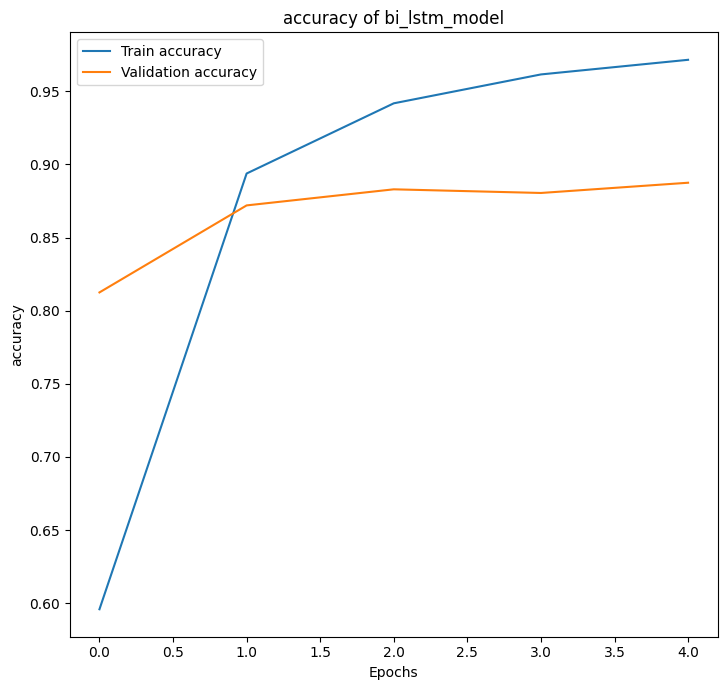

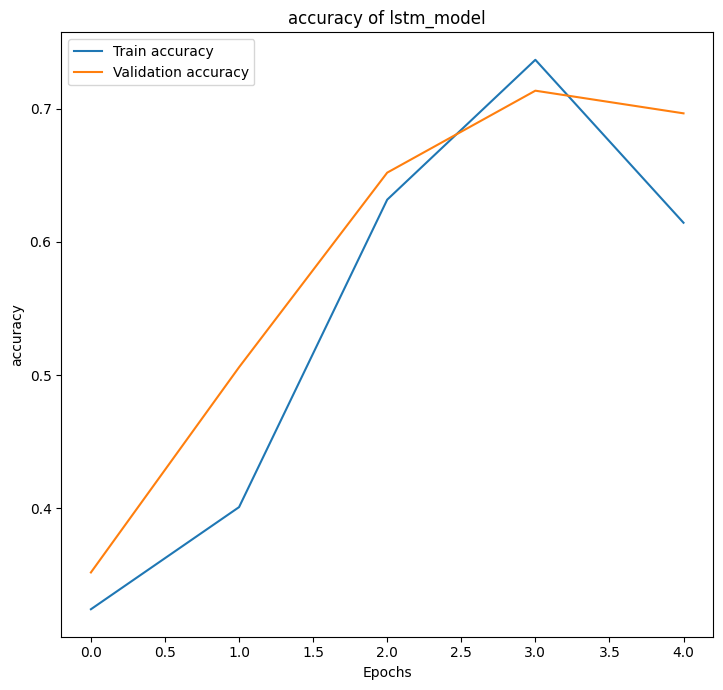

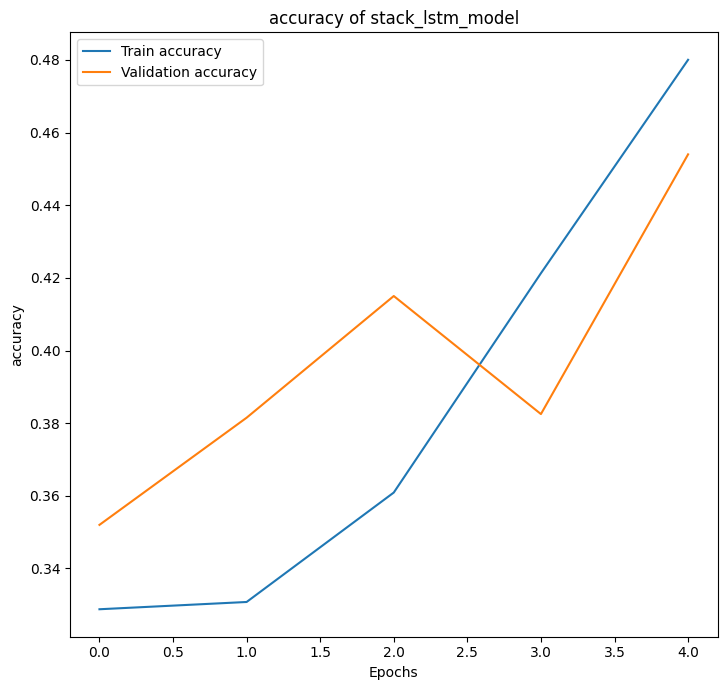

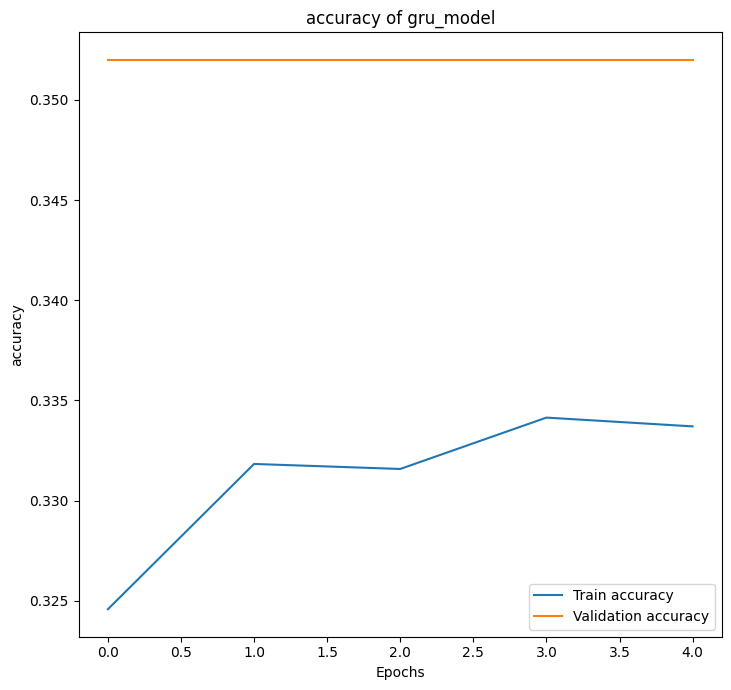

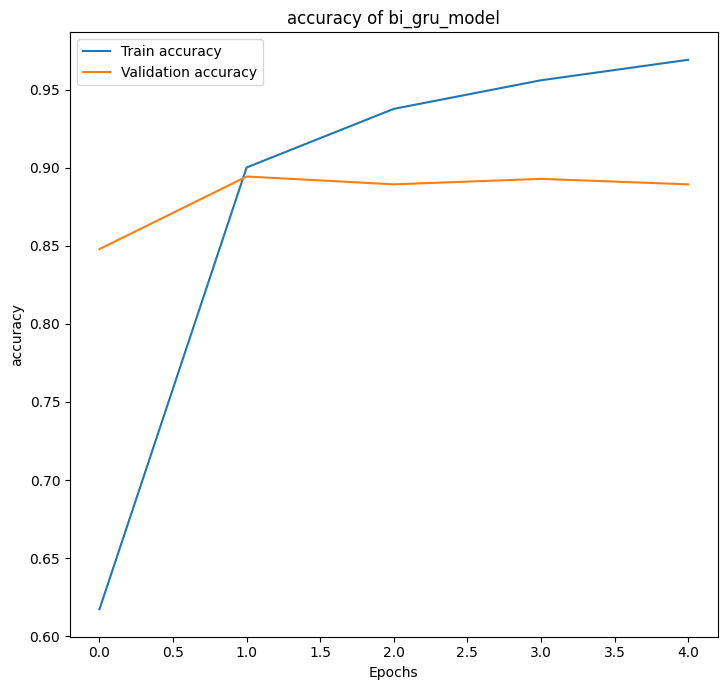

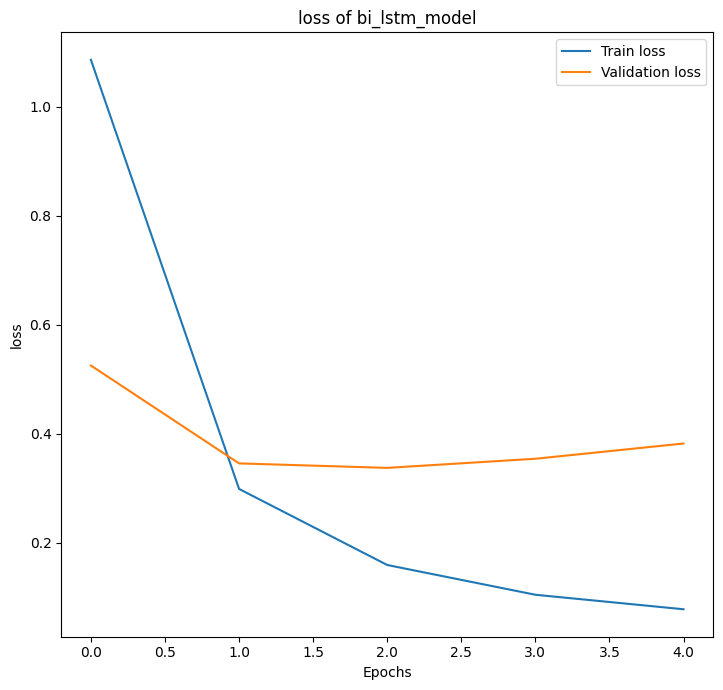

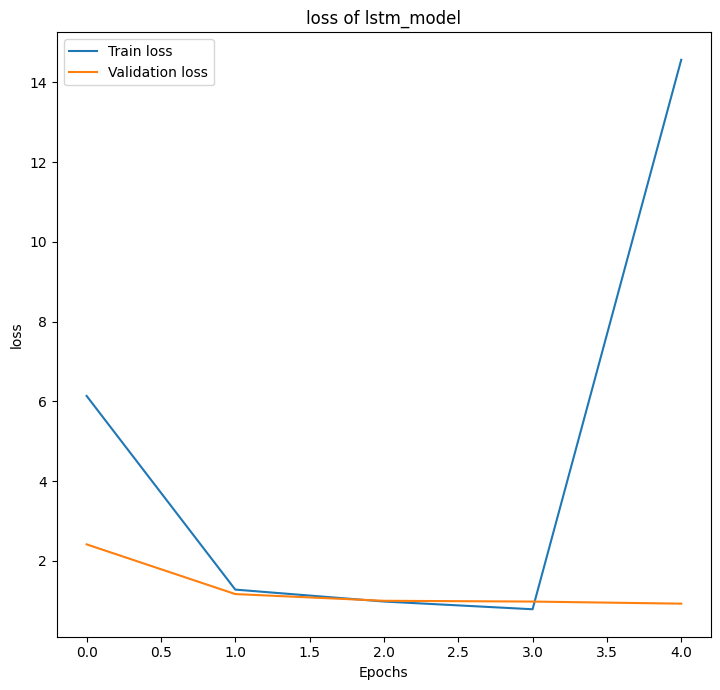

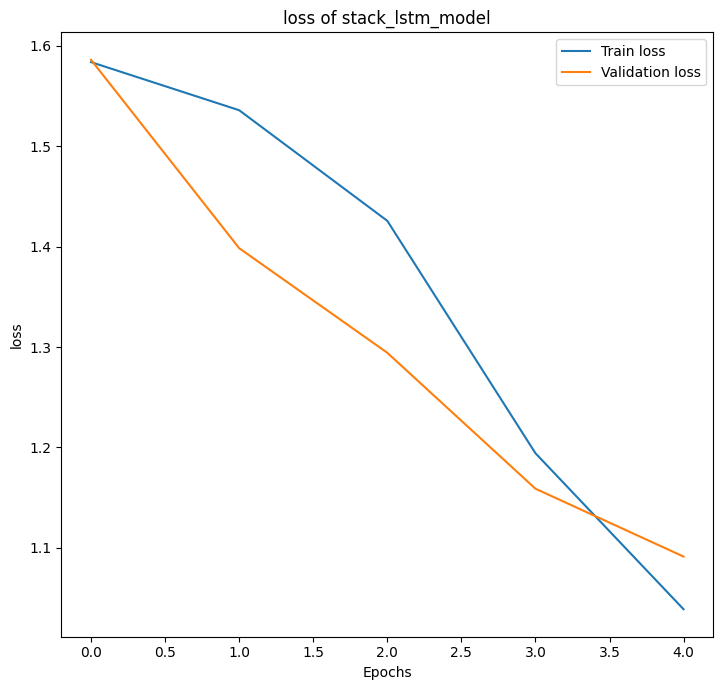

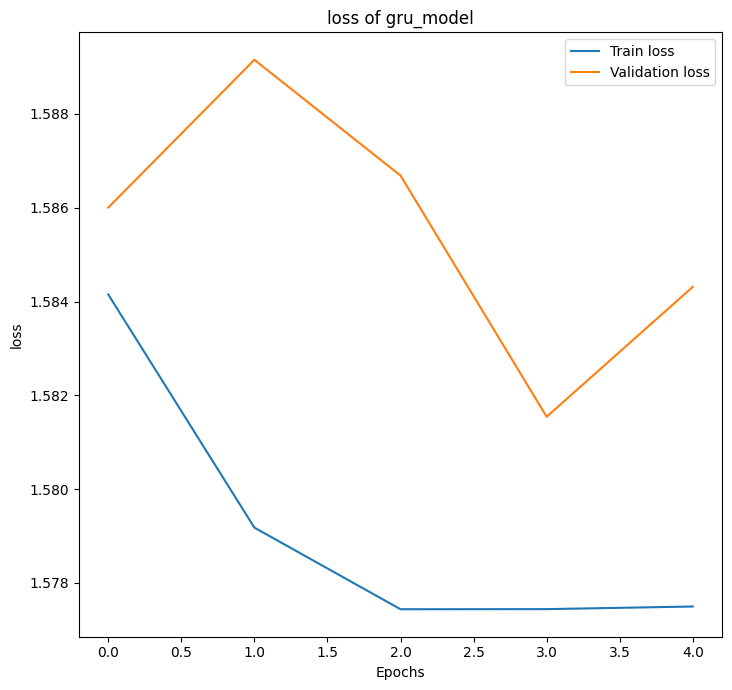

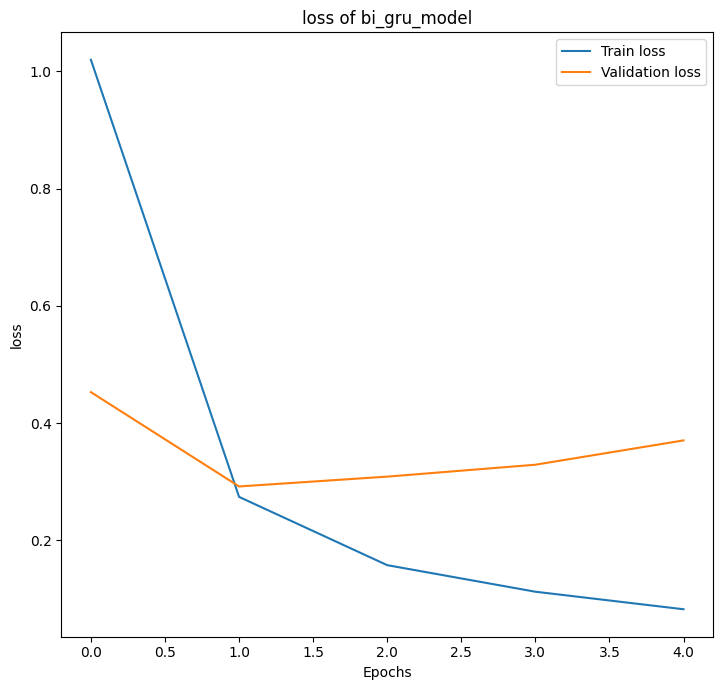

In [ ]:
for metric in ["accuracy","loss"]:
  accuracy_plot(bi_lstm_model_training_history,'bi_lstm_model',metric)
  accuracy_plot(lstm_model_history,'lstm_model',metric)
  accuracy_plot(stack_model_history,'stack_lstm_model',metric)
  accuracy_plot(gru_model_history,'gru_model',metric)
  accuracy_plot(custom_bidirectional_gru_model_history,'bi_gru_model',metric)

In [ ]:
# Predicting the output probabilities of each model on test data for model evaluation
y_pred_bilstm = bi_lstm_model.predict(x_test_model)
y_pred_lstm = custom_lstm_model.predict(x_test_model)
y_pred_bigru = custom_bidirectional_gru_model.predict(x_test_model)
y_pred_gru = custom_gru_model.predict(x_test_model)


# Converting the continuous output probabilities into discrete classes (binary predictions)
y_pred_bilstm = (y_pred_bilstm > 0.5).astype(int)
y_pred_lstm = (y_pred_lstm > 0.5).astype(int)
y_pred_bigru = (y_pred_bigru > 0.5).astype(int)
y_pred_gru = (y_pred_gru > 0.5).astype(int)



63/63 [==============================] - 1s 12ms/step


In [ ]:
# Predicting the evaluagion metrics and converting the results into a dataframe


result = {"Model Name":['Bidirectional LSTM',"LSTM", "Bidirectional GRU","GRU"],
         "Accuracy Score":[accuracy_score(y_test_model,y_pred_bilstm),accuracy_score(y_test_model,y_pred_lstm),accuracy_score(y_test_model,y_pred_bigru),accuracy_score(y_test_model,y_pred_gru)],
         "F1 Score(macro)":[f1_score(y_test_model,y_pred_bilstm,average='macro'),f1_score(y_test_model,y_pred_lstm,average='macro'),f1_score(y_test_model,y_pred_bigru,average='macro'),f1_score(y_test_model,y_pred_gru,average='macro')],
         "Recall Score(macro)":[recall_score(y_test_model,y_pred_bilstm,average='macro'),recall_score(y_test_model,y_pred_lstm,average='macro'),recall_score(y_test_model,y_pred_bigru,average='macro'),recall_score(y_test_model,y_pred_gru,average='macro')],
         "Precision Score(macro)":[precision_score(y_test_model,y_pred_bilstm,average='macro'),precision_score(y_test_model,y_pred_lstm,average='macro'),precision_score(y_test_model,y_pred_bigru,average='macro'),precision_score(y_test_model,y_pred_gru,average='macro')],
         "F1 Score(micro)":[f1_score(y_test_model,y_pred_bilstm,average='micro'),f1_score(y_test_model,y_pred_lstm,average='micro'),f1_score(y_test_model,y_pred_bigru,average='micro'),f1_score(y_test_model,y_pred_gru,average='micro')],
         "Recall Score(micro)":[recall_score(y_test_model,y_pred_bilstm,average='micro'),recall_score(y_test_model,y_pred_lstm,average='micro'),recall_score(y_test_model,y_pred_bigru,average='micro'),recall_score(y_test_model,y_pred_gru,average='micro')],
         "Precision Score(micro)":[precision_score(y_test_model,y_pred_bilstm,average='micro'),precision_score(y_test_model,y_pred_lstm,average='micro'),precision_score(y_test_model,y_pred_bigru,average='micro'),precision_score(y_test_model,y_pred_gru,average='micro')],}

result_df = pd.DataFrame(result)

result_df.to_excel("Report of Trained Model.xlsx")

display(result_df)

,Model Name,Accuracy Score,F1 Score(macro),Recall Score(macro),Precision Score(macro),F1 Score(micro),Recall Score(micro),Precision Score(micro)
0,Bidirectional LSTM,0.8755,0.836340,0.832195,0.842878,0.882116,0.8755,0.888832
1,LSTM,0.4950,0.271141,0.255996,0.290959,0.630774,0.4950,0.869183
2,Bidirectional GRU,0.8835,0.842741,0.823386,0.865448,0.887271,0.8835,0.891074
3,GRU,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000


# 6. Predictive System to perform prediction on custom data

In [ ]:
import numpy as np

def predict_emotion_of_text(text):
    # Preprocess the input text
    processed_text = preprocess_text(text)

    # Convert processed text to sequences using tokenizer
    text_to_sequence = tokenizer_instance.texts_to_sequences([processed_text])[0]

    # Pad the sequence to ensure consistent length
    padded_sequence = pad_sequences([text_to_sequence], maxlen=50, padding='post')

    # Use the Bidirectional GRU model for prediction
    prediction = custom_bidirectional_gru_model.predict(padded_sequence)[0]

    # Define the classes for emotions
    classes = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

    # Print the input text and predicted emotion
    print("Input: ", text)
    print("Predicted Emotion: ", classes[np.argmax(prediction)])
    print("\n")


In [ ]:
# Testing model output with custom data

predict_emotion_of_text("Today is a bad day for me")
predict_emotion_of_text("she always gets angry if she doesn't get her own way")
predict_emotion_of_text("That horror movie is so scary")
predict_emotion_of_text("Wow! what a lovely surprise")

1/1 [==============================] - 0s 26ms/step
Input:  Today is a bad day for me
Predicted Emotion:  sadness


1/1 [==============================] - 0s 23ms/step
Input:  she always gets angry if she doesn't get her own way
Predicted Emotion:  anger


1/1 [==============================] - 0s 24ms/step
Input:  That horror movie is so scary
Predicted Emotion:  fear


1/1 [==============================] - 0s 23ms/step
Input:  Wow! what a lovely surprise
Predicted Emotion:  surprise


